Data Cleaning

In [22]:
import pandas as pd
import numpy as np

df = pd.read_csv('..\data\counterfeit_products.csv')
print(df)
column_to_drop = ['category', 'product_id', 'seller_id', 'brand', 'spelling_errors', 'domain_age_days', 'contact_info_complete', 
                  'return_policy_clear', 'payment_methods_count', 'listing_date', 'seller_country', 'views', 'certification_badges', 'warranty_months', 'bulk_orders',
                  'unusual_payment_patterns', 'ip_location_mismatch', 'shipping_origin']
df = df.drop(column_to_drop, axis=1)
print(df)
df.to_csv('..\data\cleaned_counterfeit_products.csv', index=False)

     product_id    seller_id          category            brand   price  \
0      dcb12716  seller_5426       Electronics       DigitalPro  218.54   
1      d1f8b777  seller_4385      Luxury Goods         TechCrop   20.72   
2      9989f13a  seller_2528           Fashion   FashionForward   18.87   
3      4e008120  seller_8099       Electronics    CircuitMaster   79.27   
4      933b65ba  seller_7873      Luxury Goods     PremiumCraft  225.98   
...         ...          ...               ...              ...     ...   
4995   134b692c  seller_7351   Pharmaceuticals  HealthCare Plus   55.29   
4996   52543a23  seller_3051      Luxury Goods      LuxuryBrand   12.80   
4997   bfae7e37  seller_8274      Luxury Goods      EliteDesign  293.09   
4998   bc618758  seller_5933      Luxury Goods      EliteDesign  167.47   
4999   f7efbc83  seller_5295  Automotive Parts    AutoParts Pro  401.46   

      seller_rating  seller_reviews  product_images  description_length  \
0               4.9     

<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:4: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\USER\AppData\Local\Temp\ipykernel_72124\2465614143.py:4: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\data\counterfeit_products.csv')
C:\Users\USER\AppData\Local\Temp\ipykernel_72124\2465614143.py:11: SyntaxWarning: invalid escape sequence '\d'
  df.to_csv('..\data\cleaned_counterfeit_products.csv', index=False)


In [23]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('..\data\cleaned_counterfeit_products.csv')

le = LabelEncoder()
df['is_counterfeit'] = le.fit_transform(df['is_counterfeit'])

print(df)

       price  seller_rating  seller_reviews  product_images  \
0     218.54            4.9            5291               7   
1      20.72            3.2              29               2   
2      18.87            3.9              14               2   
3      79.27            4.9            8533               4   
4     225.98            3.8            7655               4   
...      ...            ...             ...             ...   
4995   55.29            4.3            4744               3   
4996   12.80            2.4              44               2   
4997  293.09            4.6            7255               8   
4998  167.47            3.0              14               1   
4999  401.46            4.3            5721               5   

      description_length  shipping_time_days  purchases  wishlist_adds  \
0                    220                   7         99             23   
1                    179                  41        252             88   
2                    

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\USER\AppData\Local\Temp\ipykernel_72124\3885791276.py:3: SyntaxWarning: invalid escape sequence '\d'
  df = pd.read_csv('..\data\cleaned_counterfeit_products.csv')


Train test set preparation

In [87]:
from sklearn.model_selection import train_test_split

X = df.drop('is_counterfeit', axis=1)
y = df['is_counterfeit']

high_corr = ['product_images', 'seller_reviews', 'description_length', 'shipping_time_days']
X_filtered = X.drop(columns=high_corr)
print(X_filtered)

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y, test_size=0.20, random_state=42, stratify=y
)

# validation set
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(y.value_counts(normalize=True))

       price  seller_rating  purchases  wishlist_adds
0     218.54            4.9         99             23
1      20.72            3.2        252             88
2      18.87            3.9        306              6
3      79.27            4.9          7             46
4     225.98            3.8          9              5
...      ...            ...        ...            ...
4995   55.29            4.3         38              3
4996   12.80            2.4         35             19
4997  293.09            4.6        344             51
4998  167.47            3.0        155             79
4999  401.46            4.3        130             76

[5000 rows x 4 columns]
is_counterfeit
0    0.706
1    0.294
Name: proportion, dtype: float64


Check on best hyperparameter

In [50]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

model = xgb.XGBClassifier(
    objective='binary:logistic',    
    eval_metric='auc',
    random_state=42
)

param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.5],
    'scale_pos_weight': [1, 2, 2.4, 3, 5],
    'min_child_weight': [1, 3, 5],
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=200,            
    scoring='roc_auc',        
    cv=5,                          
    verbose=1,
    random_state=42,
    n_jobs=-1                       
)

random_search.fit(X_train, y_train)

print("Best AUC score:", random_search.best_score_)
print("Best parameters:", random_search.best_params_)


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Best AUC score: 1.0
Best parameters: {'subsample': 1.0, 'scale_pos_weight': 2.4, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 5, 'colsample_bytree': 1.0}


Model training

In [88]:
model = xgb.XGBClassifier(
    objective='binary:logistic',    
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    subsample=1.0,
    reg_lambda=1.5,
    reg_alpha=0.5,
    n_estimators=500,
    max_depth=3,
    learning_rate=0.01,
    gamma=0,
    colsample_bytree=0.8,
    scale_pos_weight= 2.4,
    min_child_weight=3
)

model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],
    verbose=True
)

[0]	validation_0-auc:0.97539
[1]	validation_0-auc:0.99135
[2]	validation_0-auc:0.99135
[3]	validation_0-auc:0.99135
[4]	validation_0-auc:0.99200
[5]	validation_0-auc:0.99200
[6]	validation_0-auc:0.99230
[7]	validation_0-auc:0.99230
[8]	validation_0-auc:0.99230
[9]	validation_0-auc:0.99169
[10]	validation_0-auc:0.99167
[11]	validation_0-auc:0.99151
[12]	validation_0-auc:0.99151
[13]	validation_0-auc:0.99211
[14]	validation_0-auc:0.99211
[15]	validation_0-auc:0.99211
[16]	validation_0-auc:0.99211
[17]	validation_0-auc:0.99211
[18]	validation_0-auc:0.99211
[19]	validation_0-auc:0.99211
[20]	validation_0-auc:0.99211
[21]	validation_0-auc:0.99211
[22]	validation_0-auc:0.99211
[23]	validation_0-auc:0.99211
[24]	validation_0-auc:0.99211
[25]	validation_0-auc:0.99151
[26]	validation_0-auc:0.99151
[27]	validation_0-auc:0.99151
[28]	validation_0-auc:0.99151
[29]	validation_0-auc:0.99151
[30]	validation_0-auc:0.99151
[31]	validation_0-auc:0.99151
[32]	validation_0-auc:0.99151
[33]	validation_0-au

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:51:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[111]	validation_0-auc:0.99228
[112]	validation_0-auc:0.99230
[113]	validation_0-auc:0.99230
[114]	validation_0-auc:0.99230
[115]	validation_0-auc:0.99230
[116]	validation_0-auc:0.99230
[117]	validation_0-auc:0.99230
[118]	validation_0-auc:0.99230
[119]	validation_0-auc:0.99230
[120]	validation_0-auc:0.99230
[121]	validation_0-auc:0.99230
[122]	validation_0-auc:0.99230
[123]	validation_0-auc:0.99230
[124]	validation_0-auc:0.99230
[125]	validation_0-auc:0.99230
[126]	validation_0-auc:0.99230
[127]	validation_0-auc:0.99230
[128]	validation_0-auc:0.99230
[129]	validation_0-auc:0.99230
[130]	validation_0-auc:0.99230
[131]	validation_0-auc:0.99236
[132]	validation_0-auc:0.99236
[133]	validation_0-auc:0.99236
[134]	validation_0-auc:0.99236
[135]	validation_0-auc:0.99236
[136]	validation_0-auc:0.99236
[137]	validation_0-auc:0.99236
[138]	validation_0-auc:0.99236
[139]	validation_0-auc:0.99236
[140]	validation_0-auc:0.99236
[141]	validation_0-auc:0.99236
[142]	validation_0-auc:0.99236
[143]	va

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

Evaluation

In [89]:
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score
)

y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print(classification_report(y_test, y_pred, digits=4))
print("ROC‑AUC:", roc_auc_score(y_test, y_pred_proba).round(4))

              precision    recall  f1-score   support

           0     0.9792    0.9334    0.9558       706
           1     0.8563    0.9524    0.9018       294

    accuracy                         0.9390      1000
   macro avg     0.9177    0.9429    0.9288      1000
weighted avg     0.9431    0.9390    0.9399      1000

ROC‑AUC: 0.9935


Visualization

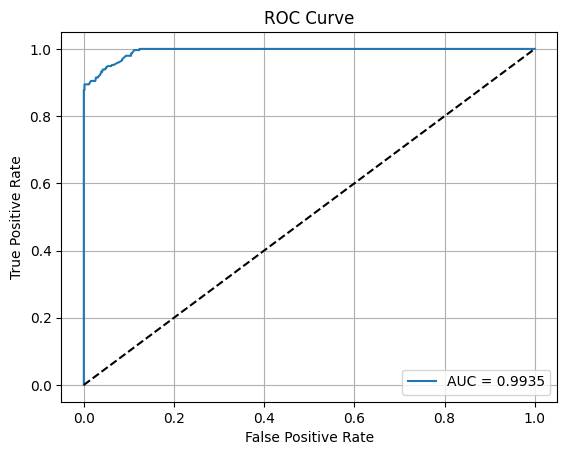

In [90]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label='AUC = {:.4f}'.format(roc_auc_score(y_test, y_pred_proba)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

In [91]:
df.corr(numeric_only=True)['is_counterfeit'].sort_values(ascending=False)

is_counterfeit        1.000000
shipping_time_days    0.867171
purchases             0.005975
wishlist_adds        -0.001506
price                -0.576817
seller_reviews       -0.684206
description_length   -0.741478
product_images       -0.772673
seller_rating        -0.809984
Name: is_counterfeit, dtype: float64

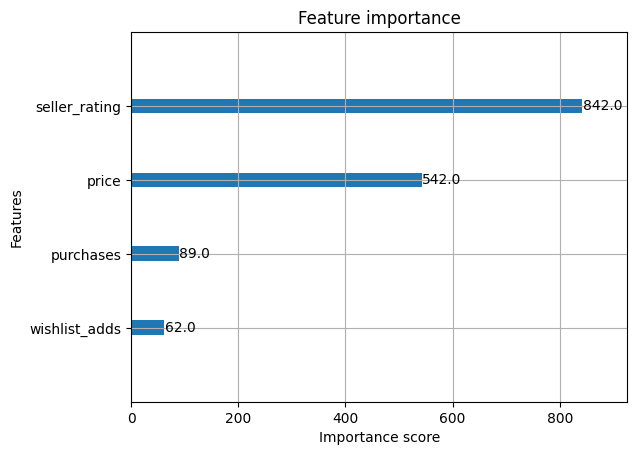

In [92]:
xgb.plot_importance(model, max_num_features=50)
plt.show()

In [93]:
import joblib

joblib.dump(model, 'CtfPd_model.pkl')

['CtfPd_model.pkl']